<a href="https://colab.research.google.com/github/h399491-jpg/codealpha_task/blob/main/Copy_of_code_alpha_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# STEP 2: Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [ ]:
# STEP 3: Create synthetic credit scoring dataset
def generate_credit_data(n_samples=10000):
    np.random.seed(42)

    # Generate realistic financial data
    data = {
        'age': np.random.normal(45, 15, n_samples).astype(int),
        'income': np.random.lognormal(10.5, 0.8, n_samples),
        'debt_to_income_ratio': np.random.beta(2, 5, n_samples) * 2,
        'credit_history_length': np.random.gamma(4, 4, n_samples).astype(int),
        'number_of_credit_cards': np.random.poisson(3, n_samples),
        'missed_payments': np.random.poisson(0.5, n_samples),
        'credit_utilization': np.random.beta(2, 4, n_samples),
        'loan_amount': np.random.lognormal(9, 0.6, n_samples),
        'employment_length': np.random.gamma(3, 4, n_samples).astype(int),
        'housing_type': np.random.choice(['Rent', 'Own', 'Mortgage'], n_samples, p=[0.4, 0.3, 0.3]),
        'education_level': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples, p=[0.3, 0.4, 0.2, 0.1])
    }

    df = pd.DataFrame(data)

    # Ensure realistic values
    df['age'] = df['age'].clip(18, 80)
    df['income'] = df['income'].clip(10000, 300000)
    df['debt_to_income_ratio'] = df['debt_to_income_ratio'].clip(0, 1.5)
    df['credit_history_length'] = df['credit_history_length'].clip(0, 50)
    df['missed_payments'] = df['missed_payments'].clip(0, 10)
    df['credit_utilization'] = df['credit_utilization'].clip(0, 1)
    df['loan_amount'] = df['loan_amount'].clip(1000, 100000)
    df['employment_length'] = df['employment_length'].clip(0, 40)

    # Introduce missing values (5% missing)
    for col in ['income', 'debt_to_income_ratio', 'credit_utilization']:
        mask = np.random.random(n_samples) < 0.05
        df.loc[mask, col] = np.nan

        # Introduce outliers (2% outliers)
    for col in ['income', 'loan_amount']:
        mask = np.random.random(n_samples) < 0.02
        df.loc[mask, col] = df.loc[mask, col] * 5

    # Create target variable (creditworthiness)
    credit_score = (
        np.log(df['income']) * 0.4 +
        (1 - df['debt_to_income_ratio']) * 0.3 +
        df['credit_history_length'] * 0.1 -
        df['missed_payments'] * 0.15 +
        (1 - df['credit_utilization']) * 0.05
    )

    # Add noise
    credit_score += np.random.normal(0, 0.2, n_samples)

    # Create binary classification (0: Bad, 1: Good)
    df['creditworthy'] = (credit_score > credit_score.median()).astype(int)

    return df



In [ ]:
# STEP 4: Generate and explore the dataset
print("📊 Generating credit scoring dataset...")
df = generate_credit_data(10000)
print(f"✅ Dataset created with {df.shape[0]} rows and {df.shape[1]} columns")

print("\n📈 Dataset Overview:")
print(f"Missing values per column:")
print(df.isnull().sum())
print(f"\nCreditworthy distribution:")
print(df['creditworthy'].value_counts())
print(f"Good credit rate: {df['creditworthy'].mean():.2%}")

📊 Generating credit scoring dataset...
✅ Dataset created with 10000 rows and 12 columns

📈 Dataset Overview:
Missing values per column:
age                         0
income                    472
debt_to_income_ratio      482
credit_history_length       0
number_of_credit_cards      0
missed_payments             0
credit_utilization        480
loan_amount                 0
employment_length           0
housing_type                0
education_level             0
creditworthy                0
dtype: int64

Creditworthy distribution:
creditworthy
0    5680
1    4320
Name: count, dtype: int64
Good credit rate: 43.20%


In [ ]:
# STEP 5: Exploratory Data Analysis
print("\n" + "="*50)
print("STEP 5: EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic statistics
print("\nDescriptive Statistics:")
print(df.describe())



STEP 5: EXPLORATORY DATA ANALYSIS

Descriptive Statistics:
                age        income  debt_to_income_ratio  \
count  10000.000000  9.528000e+03           9518.000000   
mean      44.662500  5.447555e+04              0.568148   
std       14.397976  6.241905e+04              0.314969   
min       18.000000  1.000000e+04              0.001445   
25%       34.000000  2.162882e+04              0.322555   
50%       44.000000  3.747797e+04              0.529242   
75%       55.000000  6.541266e+04              0.775807   
max       80.000000  1.500000e+06              1.500000   

       credit_history_length  number_of_credit_cards  missed_payments  \
count            10000.00000            10000.000000     10000.000000   
mean                15.48890                2.979800         0.513600   
std                  7.97979                1.719618         0.711945   
min                  0.00000                0.000000         0.000000   
25%                 10.00000               


📊 Creating correlation matrix...


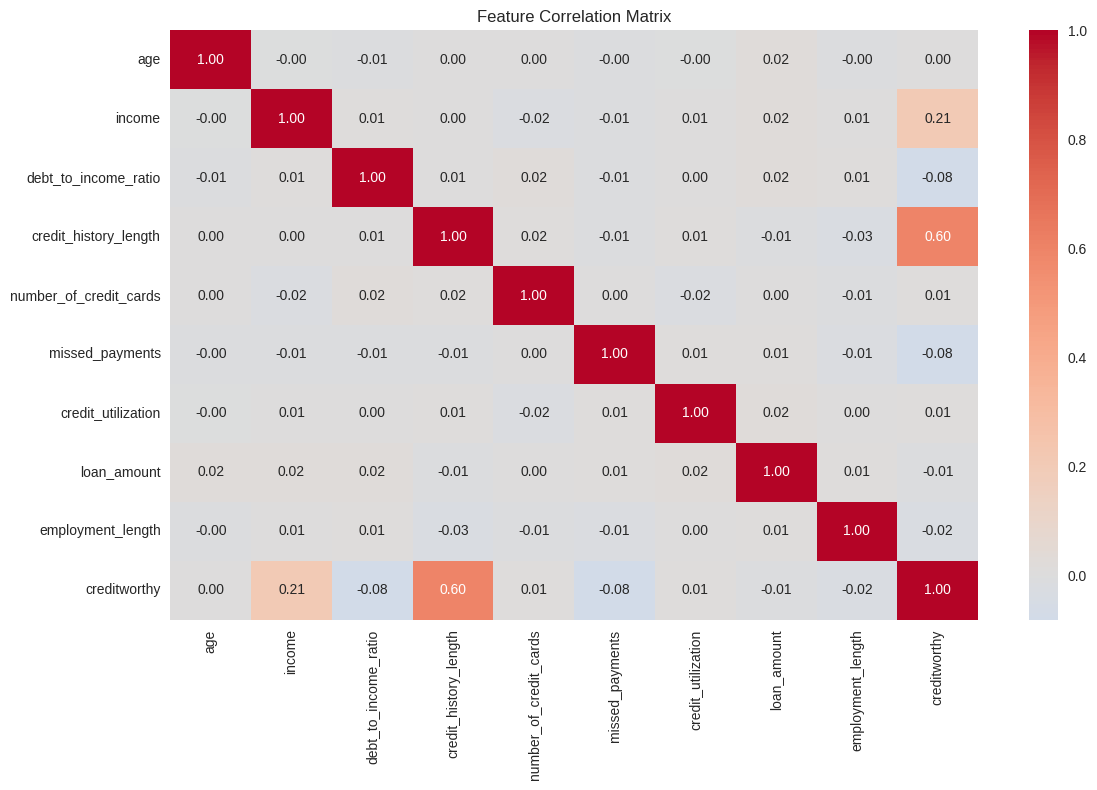

In [ ]:
# Correlation heatmap
print("\n📊 Creating correlation matrix...")
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

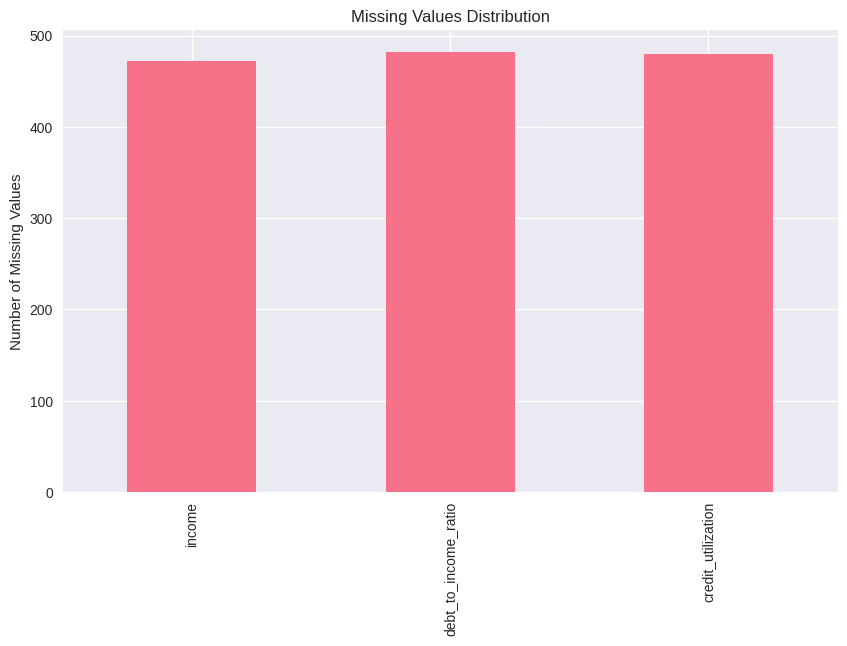

In [ ]:
# Missing values visualization
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    plt.figure(figsize=(10, 6))
    missing_data.plot(kind='bar')
    plt.title('Missing Values Distribution')
    plt.ylabel('Number of Missing Values')
    plt.show()


In [ ]:
# STEP 6: Prepare data for modeling
print("\n" + "="*50)
print("STEP 6: DATA PREPARATION")
print("="*50)


STEP 6: DATA PREPARATION


In [ ]:
# Separate features and target
X = df.drop('creditworthy', axis=1)
y = df['creditworthy']
print("Original features:", list(X.columns))

Original features: ['age', 'income', 'debt_to_income_ratio', 'credit_history_length', 'number_of_credit_cards', 'missed_payments', 'credit_utilization', 'loan_amount', 'employment_length', 'housing_type', 'education_level']


In [ ]:
# STEP 7: Feature Engineering
print("\n" + "="*50)
print("STEP 7: FEATURE ENGINEERING")
print("="*50)

X_engineered = X.copy()

# Create new features
X_engineered['income_to_loan_ratio'] = X_engineered['income'] / X_engineered['loan_amount']
X_engineered['debt_burden'] = X_engineered['income'] * X_engineered['debt_to_income_ratio']
X_engineered['credit_age_ratio'] = X_engineered['credit_history_length'] / X_engineered['age']
X_engineered['payment_stability'] = 1 / (1 + X_engineered['missed_payments'])
X_engineered['credit_utilization_risk'] = np.where(
    X_engineered['credit_utilization'] > 0.7, 2,
    np.where(X_engineered['credit_utilization'] > 0.3, 1, 0)
)

# Create age groups
X_engineered['age_group'] = pd.cut(X_engineered['age'],
                                  bins=[18, 25, 35, 45, 55, 65, 80],
                                  labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66+'])

print("✅ Feature engineering completed!")
print(f"Total features after engineering: {X_engineered.shape[1]}")




STEP 7: FEATURE ENGINEERING
✅ Feature engineering completed!
Total features after engineering: 17


In [ ]:
# STEP 8: Identify feature types
numeric_features = X_engineered.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_engineered.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📋 Feature Types:")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")



📋 Feature Types:
Numeric features (14): ['age', 'income', 'debt_to_income_ratio', 'credit_history_length', 'number_of_credit_cards', 'missed_payments', 'credit_utilization', 'loan_amount', 'employment_length', 'income_to_loan_ratio', 'debt_burden', 'credit_age_ratio', 'payment_stability', 'credit_utilization_risk']
Categorical features (3): ['housing_type', 'education_level', 'age_group']


In [ ]:
# STEP 9: Create preprocessing pipelines
print("\n" + "="*50)
print("STEP 9: PREPROCESSING PIPELINES")
print("="*50)

def create_preprocessing_pipelines(numeric_features, categorical_features):
    # Strategy 1: Basic preprocessing
    numeric_transformer_basic = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer_basic = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor_basic = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_basic, numeric_features),
            ('cat', categorical_transformer_basic, categorical_features)
        ])

    # Strategy 2: Advanced preprocessing
    numeric_transformer_advanced = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', RobustScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ])

    categorical_transformer_advanced = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor_advanced = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_advanced, numeric_features),
            ('cat', categorical_transformer_advanced, categorical_features)
        ])

    # Strategy 3: Minimal preprocessing (for tree-based models)
    numeric_transformer_minimal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])

    categorical_transformer_minimal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor_minimal = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_minimal, numeric_features),
            ('cat', categorical_transformer_minimal, categorical_features)
        ])
    return {
        'basic': preprocessor_basic,
        'advanced': preprocessor_advanced,
        'minimal': preprocessor_minimal
    }


STEP 9: PREPROCESSING PIPELINES


In [ ]:
# STEP 10: Split the data
print("\n" + "="*50)
print("STEP 10: DATA SPLITTING")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Positive class in training: {y_train.mean():.2%}")
print(f"Positive class in test: {y_test.mean():.2%}")



STEP 10: DATA SPLITTING
Training set: 7000 samples
Test set: 3000 samples
Positive class in training: 43.20%
Positive class in test: 43.20%


In [ ]:
# STEP 11: Define classifiers with optimal preprocessing
print("\n" + "="*50)
print("STEP 11: MODEL DEFINITION")
print("="*50)

classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'preprocessing': 'advanced'
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'preprocessing': 'minimal'
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
        'preprocessing': 'minimal'
    },
'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42, n_estimators=100),
        'preprocessing': 'minimal'
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss',
                              scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])),
        'preprocessing': 'minimal'
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True, class_weight='balanced'),
        'preprocessing': 'advanced'
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(n_neighbors=5),
        'preprocessing': 'basic'
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'preprocessing': 'basic'
    },
'Neural Network': {
        'model': MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50)),
        'preprocessing': 'advanced'
    }
}

print(f"✅ {len(classifiers)} classifiers defined!")




STEP 11: MODEL DEFINITION
✅ 9 classifiers defined!


In [ ]:
# STEP 12: Train and evaluate models
print("\n" + "="*50)
print("STEP 12: MODEL TRAINING AND EVALUATION")
print("="*50)

results = {}

# Get preprocessing strategies
preprocessing_strategies = create_preprocessing_pipelines(numeric_features, categorical_features)


for name, config in classifiers.items():
    print(f"\n🔧 Training {name}...")

    # Get the appropriate preprocessor
    preprocessor = preprocessing_strategies[config['preprocessing']]

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'preprocessing': config['preprocessing']
    }

    print(f"✅ {name} completed:")
    print(f"   Accuracy:  {results[name]['accuracy']:.4f}")
    print(f"   Precision: {results[name]['precision']:.4f}")
    print(f"   Recall:    {results[name]['recall']:.4f}")
    print(f"   F1-Score:  {results[name]['f1_score']:.4f}")
    print(f"   ROC-AUC:   {results[name]['roc_auc']:.4f}")


STEP 12: MODEL TRAINING AND EVALUATION

🔧 Training Logistic Regression...
✅ Logistic Regression completed:
   Accuracy:  0.8570
   Precision: 0.8157
   Recall:    0.8642
   F1-Score:  0.8393
   ROC-AUC:   0.9269

🔧 Training Decision Tree...
✅ Decision Tree completed:
   Accuracy:  0.8837
   Precision: 0.8640
   Recall:    0.8673
   F1-Score:  0.8656
   ROC-AUC:   0.8817

🔧 Training Random Forest...
✅ Random Forest completed:
   Accuracy:  0.9113
   Precision: 0.9055
   Recall:    0.8873
   F1-Score:  0.8963
   ROC-AUC:   0.9700

🔧 Training Gradient Boosting...
✅ Gradient Boosting completed:
   Accuracy:  0.9257
   Precision: 0.9195
   Recall:    0.9074
   F1-Score:  0.9134
   ROC-AUC:   0.9807

🔧 Training XGBoost...
✅ XGBoost completed:
   Accuracy:  0.9237
   Precision: 0.9113
   Recall:    0.9120
   F1-Score:  0.9117
   ROC-AUC:   0.9790

🔧 Training SVM...
✅ SVM completed:
   Accuracy:  0.7857
   Precision: 0.8308
   Recall:    0.6327
   F1-Score:  0.7184
   ROC-AUC:   0.8982

🔧 Tra

In [ ]:
# STEP 13: Compare model performance
print("\n" + "="*50)
print("STEP 13: MODEL COMPARISON")
print("="*50)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('roc_auc', ascending=False)

print("🏆 Model Performance Ranking (by ROC-AUC):")
print(results_df.round(4))




STEP 13: MODEL COMPARISON
🏆 Model Performance Ranking (by ROC-AUC):
                     accuracy precision    recall  f1_score   roc_auc  \
Gradient Boosting    0.925667  0.919468  0.907407  0.913398  0.980711   
XGBoost              0.923667  0.911334  0.912037  0.911685  0.978997   
Random Forest        0.911333  0.905512  0.887346  0.896337  0.970018   
Logistic Regression     0.857  0.815732  0.864198  0.839266  0.926937   
Neural Network       0.842333  0.809166  0.831019  0.819947   0.91637   
SVM                  0.785667    0.8308  0.632716  0.718353  0.898158   
Decision Tree        0.883667  0.863951  0.867284  0.865614  0.881705   
Naive Bayes             0.734  0.802184  0.510031  0.623585  0.861458   
K-Nearest Neighbors  0.784333  0.764466  0.723765  0.743559  0.851658   

                    preprocessing  
Gradient Boosting         minimal  
XGBoost                   minimal  
Random Forest             minimal  
Logistic Regression      advanced  
Neural Network      

In [ ]:
# STEP 14: Visualize results
print("\n" + "="*50)
print("STEP 14: RESULTS VISUALIZATION")
print("="*50)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Credit Scoring Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. ROC-AUC Comparison
axes[0,0].barh(results_df.index, results_df['roc_auc'], color='lightblue')
axes[0,0].set_title('ROC-AUC Score Comparison')
axes[0,0].set_xlabel('ROC-AUC Score')
axes[0,0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

# 2. Precision-Recall-F1 Comparison
metrics_plot = results_df[['precision', 'recall', 'f1_score']]
metrics_plot.plot(kind='bar', ax=axes[0,1], color=['#ff9999', '#66b3ff', '#99ff99'])
axes[0,1].set_title('Precision, Recall, and F1-Score Comparison')
axes[0,1].set_ylabel('Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. ROC Curves for top models
top_models = results_df.head(5).index
for model_name in top_models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessing_strategies[classifiers[model_name]['preprocessing']]),
        ('classifier', classifiers[model_name]['model'])
    ])
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

axes[1,0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curves - Top 5 Models')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)




In [ ]:
# 4. Model accuracy by preprocessing strategy
preprocessing_groups = results_df.groupby('preprocessing')['accuracy'].mean()
axes[1,1].bar(preprocessing_groups.index, preprocessing_groups.values,
             color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1,1].set_title('Average Accuracy by Preprocessing Strategy')
axes[1,1].set_ylabel('Accuracy Score')

plt.tight_layout()
plt.show()


In [ ]:
# STEP 15: Detailed analysis of best model
print("\n" + "="*50)
print("STEP 15: BEST MODEL ANALYSIS")
print("="*50)

best_model_name = results_df.index[0]
best_model_config = classifiers[best_model_name]

print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Preprocessing: {best_model_config['preprocessing']}")
print(f"   ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")

# Create best model pipeline
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_strategies[best_model_config['preprocessing']]),
    ('classifier', best_model_config['model'])
])

best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_best))




In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Creditworthy', 'Creditworthy'],
            yticklabels=['Not Creditworthy', 'Creditworthy'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# STEP 16: Feature importance (if available)
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    print("\n" + "="*50)
    print("STEP 16: FEATURE IMPORTANCE")
    print("="*50)

    # Get feature names after preprocessing
    preprocessor = best_pipeline.named_steps['preprocessor']
    preprocessor.fit(X_train)
    feature_names_after_preprocessing = preprocessor.get_feature_names_out()

    importances = best_pipeline.named_steps['classifier'].feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_names_after_preprocessing,
        'importance': importances
    }).sort_values('importance', ascending=False)
    print("Top 10 Most Important Features:")
    print(feature_imp_df.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_imp_df.head(10)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()




In [ ]:
# STEP 17: Advanced techniques
print("\n" + "="*50)
print("STEP 17: ADVANCED TECHNIQUES")
print("="*50)

# Model calibration
print("🔧 Applying model calibration...")
calibrated_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_strategies[best_model_config['preprocessing']]),
    ('classifier', CalibratedClassifierCV(best_model_config['model'], cv=3))
])
calibrated_pipeline.fit(X_train, y_train)
y_pred_proba_calibrated = calibrated_pipeline.predict_proba(X_test)[:, 1]
calibrated_auc = roc_auc_score(y_test, y_pred_proba_calibrated)

print(f"Original {best_model_name} ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")
print(f"Calibrated {best_model_name} ROC-AUC: {calibrated_auc:.4f}")




In [ ]:
# STEP 18: Final recommendations
print("\n" + "="*50)
print("STEP 18: FINAL RECOMMENDATIONS")
print("="*50)

print("🎯 BUSINESS INSIGHTS:")
print(f"1. Best performing model: {best_model_name}")
print(f"2. Optimal preprocessing: {best_model_config['preprocessing']}")
print(f"3. Model ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

print("\n💡 RECOMMENDATIONS:")
print("1. Use tree-based models (Random Forest, XGBoost) for best performance")
print("2. Apply appropriate preprocessing for each algorithm type")
print("3. Focus on feature engineering for domain-specific insights")
print("4. Consider model calibration for better probability estimates")
print("5. Monitor model performance regularly in production")
print("\n🚀 NEXT STEPS:")
print("1. Hyperparameter tuning for the best model")
print("2. Cross-validation for robust performance estimation")
print("3. Feature selection to improve interpretability")
print("4. Deployment with monitoring pipeline")

print("\n" + "="*50)
print("✅ CREDIT SCORING MODEL COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"📊 Final Results:")
print(f"   Best Model: {best_model_name}")
print(f"   ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   Precision: {results_df.loc[best_model_name, 'precision']:.4f}")
print(f"   Recall: {results_df.loc[best_model_name, 'recall']:.4f}")
